# Audio Chroma Extraction

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import scipy.signal as ss
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
import math
import numpy.matlib
import scipy.spatial

D:\ProgramFiles\anaconda3\envs\e207\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\ProgramFiles\anaconda3\envs\e207\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

### STFT Functions

Functions for modifying STFTs
- magSTFT calculates the normal and magnitude STFT
- logCompression applies elementwise logarithmic compression 
- harmonicSummation sums the harmonics of a log frequency STFT


In [4]:
def magSTFT(mp3file, sr = 22050, winsize = 2048, hop = 2048, gamma = 10000):
    '''
    Calculate the STFT for an MP3
    
    Arguments:
    mp3file -- target mp3 file
    
    Returns:
    S = STFT
    Smag -- magnitude STFT
    '''
    Y, sr  = lb.core.load(mp3file, sr = sr)
    f, t, S = ss.stft(Y, fs = sr, nperseg = winsize, noverlap = winsize - hop)
    Smag = np.abs(S)
    return S, Smag

In [5]:
def harmonicSummation(S_lf, bins=12, numHarmonics=5):
    '''
    Sum harmonics in a log frequency spectrogram
    
    Arguments:
    S_lf -- log frequency STFT
    bins -- bins per octave
    numHarmonics -- number of harmonics to sum
    
    Returns:
    harmonicsSummed -- logSTFT with harmonics summed
    '''
    filterBins = np.round(bins * np.log2(np.arange(numHarmonics)+1)).astype(int)
    height = np.amax(filterBins)
    filters = np.zeros((height+1, 1))
    filters[filterBins] = 1
    filters = np.flipud(filters)
    harmonicsSummed = ss.convolve2d(S_lf, filters)
    harmonicsSummed = harmonicsSummed[harmonicsSummed.shape[0] - S_lf.shape[0]:, :]
    return harmonicsSummed

In [6]:
def logCompression(F, gamma = 10000):
    '''
    Apply element-wise logarithmic compression.
    
    Arguments:
    F -- input matrix
    gamma -- scalar that controls the level of compression as ln(1 + gamma * c)
    
    Returns:
    Fc -- matrix of logarithmically compressed values.  Fc is of the same size as F.
    '''
    Fc = np.zeros_like(F)
    for x in range(0, len(F)):
        for y in range(0, len(F[0])):
            Fc[x][y] = np.log(1+gamma*F[x][y])
    return Fc

In [7]:
def plotLinearSpec(S, hop=2048, sr=22050, plotname='test', log = True):
    plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    S = abs(S)
    title = 'STFT of:  '
    if log:
        S = np.log(S)
        title = 'log STFT of:  '
    plt.imshow(S, origin='lower', cmap = 'jet', aspect = 'auto')
    plt.title(title + plotname)
    plt.xlabel('frame number')
    plt.ylabel('Chroma Feature')


### Extracting Chroma Features from input MP3

Chroma feature process
- determine the log frequency conversion matrix by calling getLogFreqConversionMatrix()
- determine the chroma conversion matrix by calling getChromaConversionMatrix()
- sum harmonics on the log frequency matrix
- compute chroma features by applying the chroma conversion matrix
- apply element-wise logarithmic compression by calling logCompression()
- L2 normalize each column by calling normL2()

In [8]:
def getLogFreqConversionMatrix(N, fs):
    '''
    Determine the log frequency conversion matrix that can be used to pre-multiply a one-sided spectrogram
    to get a log frequency spectrogram.
    
    Arguments:
    N -- analysis window size
    fs -- sampling rate
    
    Returns:
    B -- a binary matrix of shape (128, (N/2)+1).  The log frequency spectrogram can be computed
         by computing the matrix product of B and the spectrogram matrix.
    '''
    numBins = int(N/2) + 1
    pitchMax = 128
    B = np.zeros((pitchMax, numBins))
    p = np.arange(pitchMax)
    pitchFrequencies = []
    for pitch in range(0, len(p)):
        pitchFrequencies.append([440*N/fs * 2**(((pitch-0.5) - 69)/12), 440*N/fs * 2**(((pitch+0.5) - 69)/12)])
        initIndex = int(pitchFrequencies[pitch][0])
        while initIndex<pitchFrequencies[pitch][1]:
            try:
                if pitchFrequencies[pitch][0]<initIndex and initIndex<pitchFrequencies[pitch][1]:
                    B[pitch][initIndex] = 1
            except:
                pass
            initIndex +=1
    return B

In [9]:
def getChromaMatrix(logF):
    '''
    Determine the chroma feature matrix that can be used to pre-multiply a one-sided spectrogram
    to calculate chroma features.
    
    Arguments:
    logF -- log Frequency STFT(can have harmonics summed)
    
    Returns:
    F -- a chroma feature matrix with the same number of columns as the STFT, but only 12 rows
    '''
    F = np.zeros([12, logF.shape[1]])
    for c in range(0, logF.shape[1]):
        for x in range(0, 12):
            num = 0
            for y in range(x, logF.shape[0], 12):
                num += logF[y][c]
            F[x][c] += num
    return F

In [10]:
def normL2(F):
    '''
    Normalize each column of a matrix to have unit L2 norm.
    
    Arguments:
    F -- input feature matrix where each column corresponds to a single feature vector
    
    Returns:
    Fnorm -- normalized feature matrix of the same shape as F, where each column has been
             been normalized to be unit L2 norm
    '''
    row, col = F.shape
    for x in range(0, col):
        norm = np.linalg.norm(F[:,x])
        F[:,x] = F[:,x]/ (norm + 1e-9)
    Fnorm = F
    return Fnorm

In [11]:
def extractChromaFeatures(mp3file, sr = 22050, winsize = 2048, hop = 2048, gamma = 10000):
    '''
    Compute chroma feature matrix on a specified audio file.
    
    Arguments:
    Smag --  magnitude STFT
    sr -- desired sampling rate in Hz
    winsize -- analysis window size in samples
    hop -- hop size in samples
    gamma -- coefficient used in log compression
    
    Returns:
    F -- chroma feature matrix of size (12, M), where M is the number of audio frames.  The
         features have logarithmic compression and each column is L2 normalized.
    '''
    S,Smag = magSTFT(mp3file)
    height, width = Smag.shape
    B = getLogFreqConversionMatrix(winsize, sr)
    logF = np.dot(B,Smag)
    logFsummedHarmonics = harmonicSummation(logF)
    f = getChromaMatrix(logFsummedHarmonics) #Change logFsummedHarmonics to logF to test without harmonic summation
    f1 = logCompression(f, gamma)
    F = normL2(f1)
    return F

# Score Chroma Features

In [12]:
C = [1,0,0,0,0,0,0,0,0,0,0,0]
Cs = [0,1,0,0,0,0,0,0,0,0,0,0]
D = [0,0,1,0,0,0,0,0,0,0,0,0]
Ds = [0,0,0,1,0,0,0,0,0,0,0,0]
E = [0,0,0,0,1,0,0,0,0,0,0,0]
F = [0,0,0,0,0,1,0,0,0,0,0,0]
Fs = [0,0,0,0,0,0,1,0,0,0,0,0]
G = [0,0,0,0,0,0,0,1,0,0,0,0]
Gs = [0,0,0,0,0,0,0,0,1,0,0,0]
A = [0,0,0,0,0,0,0,0,0,1,0,0]
As = [0,0,0,0,0,0,0,0,0,0,1,0]
B = [0,0,0,0,0,0,0,0,0,0,0,1]


# A = "A"
# As = "As"
# B = "B"
# C = "C"
# Cs = "Cs"
# D = "D"
# Ds = "Ds"
# E = "E"
# F = "F"
# Fs = "F"
# G = "G"
# Gs = "Gs"


one = np.transpose(np.vstack([A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A]))

two = np.transpose(np.vstack([C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,
       Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,
       B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C]))
three = np.transpose(np.vstack([E,D,C,D,E,E,E,D,D,D,E,G,G,E,D,C,D,E,E,E,D,D,D,E,D,C]))
#threeT = [3,1,2,2,2,2,4,2,2,4,2,2,4,3,1,2,2,2,2,4,2,1,1,2,2,6]
four = np.transpose(np.vstack([A,B,Cs,A,B,Cs,B,A,G,Fs,G,A,B,G,E,A,B,Cs,A,B,Cs,B,A,G,
       Fs,B,G,E,A,A,B,Cs,A,B,Cs,B,A,G,Fs,G,A,B,G,E,A,B,Cs,A,B,Cs,B,A,G,
       Fs,B,G,E,A]))
five = np.transpose(np.vstack([Gs,As,C,Cs,Ds,F,G,Gs,As,C,Cs,Ds,F,G,Gs,
        G,F,Ds,Cs,C,As,Gs,G,F,Ds,Cs,C,As,Gs,
        As,C,Cs,Ds,F,G,Gs,As,C,Cs,Ds,F,G,Gs,
        G,F,Ds,Cs,C,As,Gs,G,F,Ds,Cs,C,As,Gs]))
six = np.transpose(np.vstack([Cs, D, F, As, As, Cs, D, F, Gs, Gs, F, G, Cs, D, F, F, Gs,
    C, C, D, F, F, F, Ds, D, C, D, Ds, D, C, As, C, D, C, As, A, As,
    Cs, B, A, G, A, C, As, Gs, G, F]))

seven = np.transpose(np.vstack([Gs, B, Gs, B, Gs, Gs, B, Gs, B, Gs, Gs, B, Gs, B, Gs, 
    Cs, Gs, B, Gs, Cs, Gs, Cs, B, Gs, Cs, Cs, Cs, Fs, As, Fs, Cs, As, 
    Gs, G, Fs, D, Cs, D, Cs, Cs, E, Cs, E, Fs, Cs, E, Cs, Cs, E, Cs, A, Gs, E, Cs]))

eight = np.transpose(np.vstack([B, As, B, As, Ds, Fs, F, As, Ds, C, B, As, B, As, Ds, Fs, F, As, C, 
    Ds, B, As, B, As, Ds, Fs, F, As, Ds, C, B, As, B, As, Ds, Fs, F, As, C, Ds,
    As, C, Cs, G, F, Ds, F, G, D, C, Gs, A, As, Gs, G, Ds]))

nine = np.transpose(np.vstack([G,E,E,F,D,D,C,D,E,F,G,G,G,G,E,E,E,F,D,D,D,C,E,G,G,E,E,
    E,D,D,D,D,D,E,F,E,E,E,E,E,F,G,G,E,E,E,F,D,D,D,C,E,G,G,E,E,E]))
ten = np.transpose(np.vstack([G,A,G,F,E,F,G,D,E,F,E,F,G,G,A,G,F,E,F,G,D,G,E,C]))
eleven = np.transpose(np.vstack([C,D,E,F,G,A,B,C,B,A,G,F,E,D,C,E,G,C,G,E,C]))
twelve = np.transpose(np.vstack([C,C,G,G,A,A,G,F,F,E,E,D,D,C,G,G,F,F,E,E,D,G,G,F,F,E,E,D,C,C,G,G,A,A,G,F,F,E,E,D,D,C]))
thirteen = np.transpose(np.vstack([A, Fs, D, Fs, G, A, As, C, D, Ds, Fs, G, D, A, Fs, D, Fs, G, D, Cs,As, A, G, Fs, Fs, D, A, Fs, D, As, A, G, A, As, C, D, Ds, Fs, G, D, A, Fs, D, Fs, G, D, Cs, As, A, G, Fs, Fs, D]))
fourteen = np.transpose(np.vstack([C,C,D,C,F,E,C,C,D,C,G,F,C,C,C,A,F,E,D,As,As,A,F,G,F,C,C,D,C,F,E,C,C,D,C,G,F,C,C,C,A,F,E,D,As,As,A,F,G,F]))
fifteen = np.transpose(np.vstack([Fs, D, G, A, G, Fs, E, Fs, B, Cs, E, D, E, D, Cs, D, B, Cs, B, A, B,
    A, Gs, A, Cs, Cs, B, A, B, A, Gs, A, Cs, B, A, Cs, B, Cs, B, A, Cs, Cs, B, As, Cs,
    B, Cs, B, As, Fs]))
sixteen = np.transpose(np.vstack([A,B,C,D,E,F,G,A,B,C,D,E,F,G,A,G,F,E,D,C,B,A,G,F,E,D,C,B,
    A,B,C,D,E,F,G,A,B,C,D,E,F,G,A,G,F,E,D,C,B,A,G,F,E,D,C,B,A]))
seventeen = np.transpose(np.vstack([E,E,D,C,C,D,D,E,D,C,G,G,F,E,E,D,C,D,E,C,E,E,F,G,G,
    A,A,G,F,E,E,E,F,G,G,A,A,G,E,E,D,C,C,D,D,E,D,C,G,G,F,E,E,D,C,D,E,C]))
eighteen = np.transpose(np.vstack([C,F,E,F,A,C,F,F,E,D,C,F,G,A,As,D,F,G,A,
    C,G,C,F,E,F,A,C,A,A,G,F,E,F,A,D,F,E,Ds,D,E,C]))
nineteen = np.transpose(np.vstack([B,G,Fs,E,D,A,B,G,Fs,E,D,A,B,G,E,D,C,G,A,D,B,B,C,A,B,G,A,Fs,G,E,Fs,G,A,B]))
twenty = np.transpose(np.vstack([C,D,E,F,G,A,B,C,B,A,G,F,E,D,C]))
twentyone = np.transpose(np.vstack([A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,
    E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A]))

twentytwo = np.transpose(np.vstack([E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C,E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C]))

twentythree = np.transpose(np.vstack([D,C,A,C,C,D,C,G,E,C,D,C,A,C,B,B,B,B,A,G,E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C]))

twentyfour = np.transpose(np.vstack([G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,B,E,D,G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,As,A,G]))
twentyfive = np.transpose(np.vstack([Ds,C,Ds,C,As,G,As,C,D,Ds,C,Ds,As,Ds,C,E,C,As,G,As,C,D,Ds,As,C,D,G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,As,A,G]))
twentysix = np.transpose(np.vstack([A,D,E,F,E,F,B,A,G,Fs,G,D,Cs,C,B,A,Gs,A,G,G,A,B,E,E,G,G,G,Gs,Gs,Gs,A,A,B,B,B]))
twentyseven = np.transpose(np.vstack([As,C,D,As,C,D,As,C,D,F,Ds,D,As,C,Cs,Ds,F,G,Ds,F,G,Ds,F,G,As,Gs,G,Ds,F,Fs,F,G,Gs,A,B,E,G,As,B,E,Ds,C,B,A,G,F,G,Gs,As,Ds,G,As,B,E,Ds,C,As,Gs,G]))
twentyeight = np.transpose(np.vstack([G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,F,D,D,D,C,E,C,C,C,As,C,G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,F,D,D,D,C,E,C,C,C,As,C]))
twentynine = np.transpose(np.vstack([F,Fs,Ds,F,Ds,Cs,Ds,Gs,A,Gs,Fs,Gs,Fs,E,Fs,A,As,A,G,A,G,F,G,A,As,C,C,D,E,F,G,Gs,A,As,As,C,D,E,F,Fs,G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,A,F,F,F,D,C,E,E,E,D,D]))
thirty = np.transpose(np.vstack([Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,C,Ds,Ds,Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,C,Ds,Ds]))
thirtyone = np.transpose(np.vstack([Ds,C,Ds,C,Ds,C,Ds,D,As,D,As,D,Ds,C,Ds,C,Ds,C,Ds,As,C,C,C,F,Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,As,C,Ds,Ds]))
thirtytwo = np.transpose(np.vstack([G,G,As,G,F,G,G,G,As,G,F,G,G,G,As,G,F,G,G,G,As,G,F,G,D,G,A,As,As,C,As,G,G,A,As,As,F,Gs,Gs,Gs,As,Gs,Fs,F,F,F,Gs,Gs,Cs,Fs,Gs,A,A,A,B,A,Fs,Fs,A,A,A,A,A,A,B,A,Fs,Fs,A,A,D,D,C,D,C,As,D,C,C,As,As,C,C,G,G,G,F,Ds,F,G,As,G,Ds,F,Fs]))
thirtythree = np.transpose(np.vstack([A,D,C,D,C,D,E,F,G,A,As,C,D,G,F,G,F,A,As,A,D,C,D,C,D,E,F,G,A,As,C,D,G,F,G,F,A,C,D,D,D,C,As,F,G,Gs,Gs,Gs,Gs,Gs,Fs,Cs,Ds,E,E,E,E,E,D,Fs,A,Cs,Cs,As,A,D,C,D,C,D,E,F,G,A,As,C,D,E,D,A,G,F]))
thirtyfour = np.transpose(np.vstack([A,Gs,As,C,C,Ds,D,As,G,C,Ds,C,As,G,F,As,F,G,F,Gs,As,C,C,Ds,F,D,C,C,Ds,C,As,G,F,As,F,G,C,G,Ds,F,G,Gs,As,C,Gs,F,G,Gs,As,C,D,E,D,As,A,A,A,Gs,As,C,C,Ds,D,As,G,C,Ds,C,As,G,F,As,F,G,F,Gs,As,C,C,Ds,F,D,C,C,Ds,C,As,G,F,As,F,G]))
thirtyfive = np.transpose(np.vstack([D,G,A,A,B,D,G,A,As,C,F,G,G,A,C,F,G,Gs,D,Ds,F,G,G,G,G,G,G,A,G,A,As,A,G,A,B,A,B,C,D,D,D,D,D,D,G,A,A,B,D,G,A,As,C,F,G,G,A,C,F,G,Gs,D,Ds,F,G,G,G,G,G,G,A,G,A,B,A,B,C,D,D,D,D,D,D,G,A,G]))
thirtysix = np.transpose(np.vstack([A,As,A,As,A,As,A,As,A,Gs,A,C,B,As,A,A,G,G,A,G,A,G,A,G,A,G,Fs,G,As,A,Gs,G,G,F,F,G,F,G,F,G,F,G,A,F,D,E,D,E,F,F,F,G,F,G,E,F,E,F,E,Ds,E,G,Fs,F,E,E,D]))
thirtyseven = np.transpose(np.vstack([E,F,G,B,A,G,E,D,E,G,E,D,E,G,E,D,E,C,E,G,A,B,C,C,C,D,B,A,A,G,E,Fs,G,G,G,A,Fs,G,E,F,G,B,A,G,E,D,E,G,E,D,E,G,E,D,E,C,E,G,A,B,C,C,C,D,B,As,As,A,G,F,E,E,D,C,B,C]))
thirtyeight = np.transpose(np.vstack([Ds,F,G,As,C,As,C,As,Cs,C,As,Ds,F,G,As,C,As,Cs,C,As,Ds,F,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F,C,G,Cs,C,C,D,F,Cs,Gs,Cs,D,Ds,E,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F]))
thirtynine = np.transpose(np.vstack([C,Ds,G,As,A,Ds,F,G,G,G,B,D,F,D,Ds,C,Ds,F,G,Ds,C,Ds,Ds,As,G,F,D,Ds,F,G,Gs,As,As,B,Gs,D,As,C,G,C,D,Ds,D,C,As,C,D,D,G,A,As,A,G,Gs]))
forty = np.transpose(np.vstack([As,G,F,D,Ds,F,G,Gs,As,As,B,Gs,D,As,C,G,C,D,Ds,F,As,C,Cs,C,F,C,Fs,D,G,Ds,C,D,Ds,D,C,As,C,D,Cs,C,Ds,F,G,C,Ds,F,Fs,B,As,F,G,Gs,Gs,As,Gs,G,F,G,G,C,D,Ds,Ds,F,Ds,D,C,D,G,As,D,C,As,G,F,D,Ds,D,G,Gs,As,As,B,Gs,D,B,C,G,C,D,Ds,F,As,C,Cs,C,Ds,F,G,C,Ds,F,Fs,D,Ds]))
fortyone = np.transpose(np.vstack([C,B,B,A,B,C,B,A,B,B,As,E,A,E,F,G,D,E,F,F,E,F,E,F,E,E,E,E,F,E,G,F,E,D,E,D,F,E,C,C,D,E,C,D,E,A,B,G,A,B,C,B,B,A,B,C,B,A,B,B,As,E,A,E,F,G,D,E,F,F,E,F,E,F,E,G,F,E,B,Gs,A,D,As,C,A,B,A,B,C]))


# Subsequence DTW

DTW overall process
- compute the cost matrix based on cosine distance
- use dynamic programming to find our cumulative cost matrix and our backtrace matrix
- construct the optima

In [13]:
def computeCostMatrix_cosdist(Fquery,Fref):
    '''
    Computes the cosine distance cost matrix.
    
    Arguments:
    Fquery -- the query chroma feature matrix of dimension (12, # query frames), this feature
              matrix is assumed to be L2 normalized
    Fref -- the reference feature matrix, of dimension (12, # reference frames), this feature
            matrix is assumed to be L2 normalized
    
    Returns:
    C -- cost matrix whose (i,j)th element specifies the cosine distance between the i-th query frame
         and the j-th reference frame
    '''
    product = np.dot(np.transpose(Fquery), Fref)
    ones = np.ones_like(product)
    #product = scipy.spatial.distance.cdist(np.transpose(Fquery), np.transpose(Fref), metric='cosine')
    C = ones - product

    return C

In [14]:
def subsequenceDTW(C, steps, weights):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.zeros(C.shape)
    x, y = D.shape
    B = np.zeros(C.shape)
    #Initialize the first row to be the same as the Cost matrix
    for i in range(0, y):
        D[0,i] = C[0,i]
    #Loop through the rest of the entries in D, filling them with the minimum cost possible with the provided steps and weights 
    for j in range(0, y):
        for i in range(1, x):
            minimum = math.inf
            B[i,j] = -1
            for idx, step in enumerate(steps):
                if i-step[0]>-1 and j-step[1]>-1:
                    if (weights[idx] *C[i,j] + D[i-step[0], j-step[1]]) < minimum:
                        minimum = weights[idx] *C[i,j] + D[i-step[0], j-step[1]]
                        B[i,j] = idx
            D[i, j] = minimum
    #Backtrace and find the optimal path
    path = backtrace(D,B,steps)
    path = np.array(path)
    #The minimum cost value in the last row is our optimal cost
    endindex =  np.where(D[-1][:] == np.amin(D[-1][:]))[0][0]
    optcost = D[-1][endindex]
    return optcost, path


In [15]:
def backtrace(D, B, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''
    
    #Follow the steps back to row zero
    path = []
    endindex =  np.where(D[-1][:] == np.amin(D[-1][:]))[0][0]
    point = [D.shape[0]-1, endindex]
    path.append(point)
    #iterate through all transitions
    while point[0]>0:
        stepNum = B[point[0],point[1]]
        transition = steps[int(stepNum)]
        point = [int(point[0]-transition[0]),int(point[1]-transition[1])]
        path.append(point)
        
    
    return path

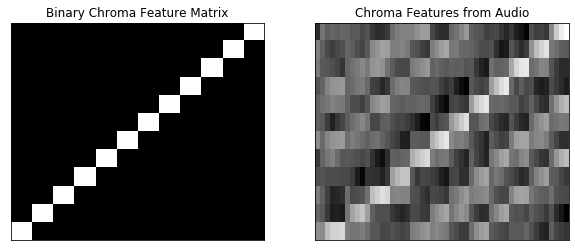

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(Fquery[:,:51], cmap = 'gray',aspect = 'auto',origin = 'lower')
ax1.imshow(two[:,:12], cmap= 'gray',aspect = 'auto', origin = 'lower')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Binary Chroma Feature Matrix')
ax2.set_title('Chroma Features from Audio')
fig.set_size_inches(10,4)
plt.show()

In [30]:
steps = np.array([1, 0, 1, 1]).reshape((2,2))
#steps = np.array([0, 1, 1, 1, 1, 2, 2, 1]).reshape((4,2)) # reversed axes
weights = [1.01,1]
Fquery = extractChromaFeatures('Recordings/2.mp3')
Fref = two
Cost = computeCostMatrix_cosdist(Fquery,Fref)
#D, path = lb.sequence.dtw(X = None, Y = None, C = Cost, metric = 'cosine',step_sizes_sigma=steps, weights_mul=weights,  subseq=True)
#optcost, path = subsequenceDTW(Cost, steps, weights)

# Important notes
So far, this just uses the built in dtw. I put my own dtw code above in case you want to use that instead. To plot my dtw patch, swap point[1] and point[0] in the plotter. I think we should just use the built in one unless we want to add functionality that isn't possible with the built in one for runtime sake

NameError: name 'path' is not defined

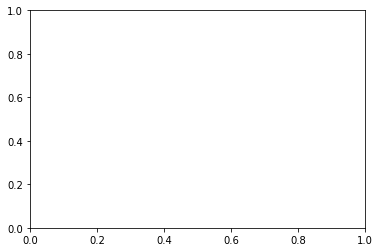

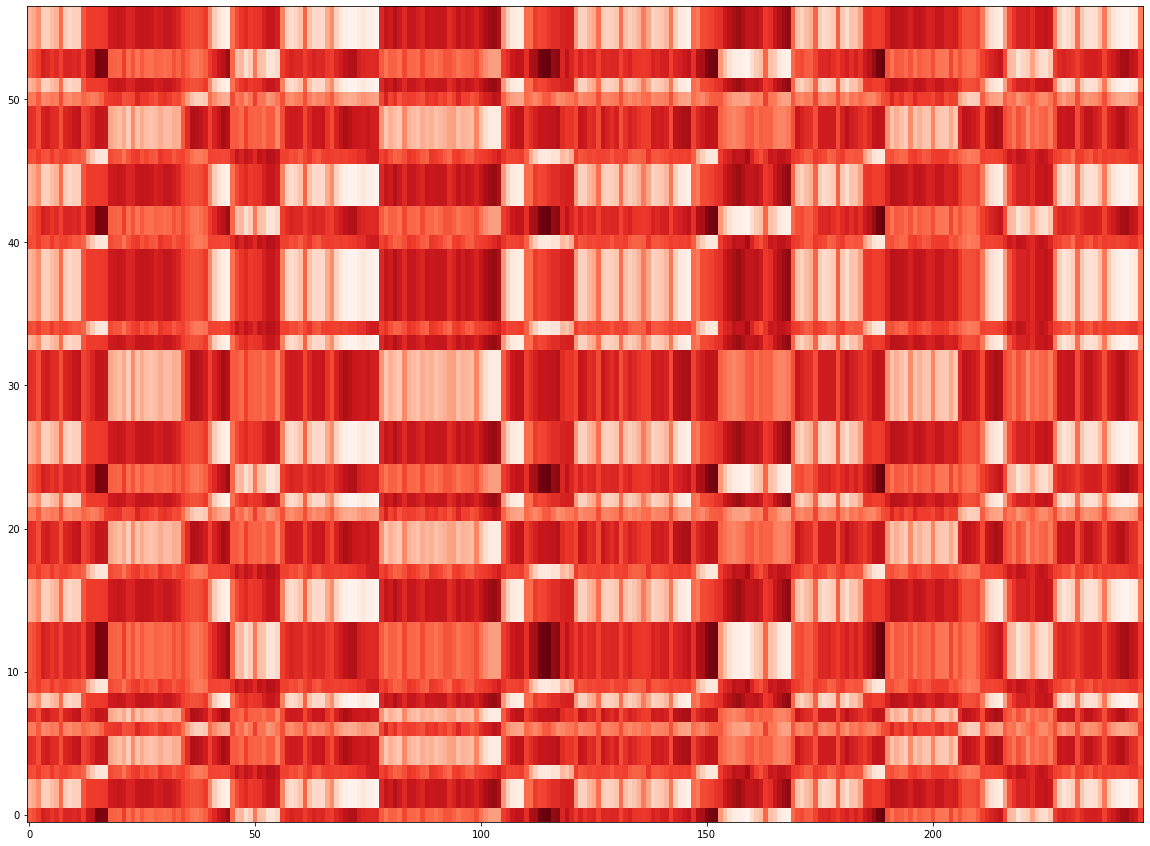

In [17]:
### START CODE BLOCK ###
import matplotlib.cm as cm
fig, ax = plt.subplots()
plt.figure(figsize=(20,15))
plot1 = plt.imshow(Cost.T, origin='lower', cmap='Reds', interpolation='nearest', aspect = 'auto')
path_x = [point[1] for point in path]
path_y = [point[0] for point in path]
plot2 = plt.plot(path_x, path_y, 'B',linewidth=6)
xlim = ax.set_xlim((-0.5, Cost.shape[0]+0.5))
ylim = ax.set_ylim((-0.5, Cost.shape[1]+0.5))
plt.colorbar()
plt.xlabel("Rows(Query points)")
plt.ylabel("Cols(Reference points)")
plt.title("Optimal Path")

In [96]:
endCol = path[1][0]

[[ 56 177]
 [ 54 176]
 [ 52 175]
 [ 50 174]
 [ 48 173]
 [ 46 172]
 [ 44 171]
 [ 42 170]
 [ 40 169]
 [ 38 168]
 [ 36 167]
 [ 34 166]
 [ 32 165]
 [ 30 164]
 [ 28 163]
 [ 26 162]
 [ 24 161]
 [ 22 160]
 [ 20 159]
 [ 18 158]
 [ 16 157]
 [ 14 156]
 [ 12 155]
 [ 10 154]
 [  8 153]
 [  6 152]
 [  4 151]
 [  2 150]
 [  0 149]]


In [45]:
print(endCol, eleven.shape[1])

20 21


In [82]:
np.arange(8).reshape(4,2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [ ]:
frame = 10
for i in range(len(Fquery[:,frame])):
    print(Fquery[i,frame])

For all of the testcases I ran, the endpoint doesnt quite match up. We have work to do lol